# Self-Driving Car Engineer Nanodegree


## Project 4: **Advanced Lane Finding ** 


In the Advanced Lane Finding project we have to track the lane markings over a series of images of a video stream using techniques like image reprojection, color/gradient segmentation and polynomal curve fitting. 

Steps that have to be performed: 
- Camera calibration 
- Image distortions 
- Image warping 
- Color/Gradient segmentation 
- Polynomal fitting
- Lane tracking 
- Visualization (mostly provided by the course)



### Library import and helper functions 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import numpy as np
import cv2
import glob 
import os
import math
import pickle

%matplotlib inline

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def plot_compare(original_image, modified_image, text_original="Original Image" ,text_modified="Modified image", gray_original=False): 
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if gray_original == False: 
        ax1.imshow(original_image)
    else: 
        ax1.imshow(original_image, cmap='gray')
    ax1.set_title(text_original, fontsize=50)
    ax2.imshow(modified_image, cmap='gray')
    ax2.set_title(text_modified, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

## Camera Calibration 

Each image taken by a camera with a lens or a set of lenses suffer (beside other aberrations) from geometric distortions which can have different impacts on the catched scene. Some of them are: 
- Straight lines does not appear as straight lines (e.g. barrel distortion,  pincushion distortion, mustache distortion)
- Objects can changes their appearance depending where they are in the image (size and shape)

"Lenses Are Not Perfect" :) 
https://classroom.udacity.com/courses/ud810/lessons/2984798536/concepts/29432285850923

Also the image frames of our project video are captured with lens camera so we have to undistort images to be able to get our straight lines straight and our scale right in every part of the image. 


Fundamental idea of calibration is having some 3D points whos geometry we know and to identify them in an captured image of the "world". Then we have to compute a mapping from the known points to the identified ones in the captured image. That way we can calculate the intrinsic and extrinsic parameters of the camera. 

### Calibration images 

The given calibration images consist of a checkerbord which is captured from different angles and distances. The checkerboard is covering multiple areas of the camera image. It is clearly not mounted in the car while taking the calibration images so the extrinsic parameters (rotation, translation) will not reflect the Pose of the camera in the car over ground. 

Usually ADAS cameras get calibrated when they are in the car with a well positioned checkerboard/marker which position is known in relation to the car. That way also the transformation matrix camera -> e.g. car rear axle can be determined too. 

Clearly we are going to use the multi-plane calibration algorithm provided by the OpenCV library to calculate the intrinsic and extrinsic parameters and the transformation matrice. By using this calibration method whe only need to know the checkerboard dimensions (number of fields in u and v direction) and the checkerboard field size to calcuate the intrisic parameters: 
- focal length 
- distortion coefficients 
and extrinsic parameters: 
- camera translation 
- camera rotation 

We do not need the checker filed size because we are moving the camera not the checker board. That way we can assume that the checker board remains in the XY plane with Z = 0. --> Scale? 

In [2]:



##  Set this to Fals if camera is not calibrated  
calibrated = True 
   

class Camera():
    def __init__(self):
        # Camera name 
        self.frame_name = "camear_default"
        # mtx = Camera Matrix 
        self.mtx = None  
        # dist = Distortion Coefficients 
        self.dist = None
        # rvecs =  Rotation
        self.rvecs = None     
        # tvecs = Translation 
        self.tvecs = None  
        # Perspective transform matrix 
        self.M = None 
        # Inverse perspective transform matrix 
        self.Minv = None 
        
        
camera = Camera()

def load_calibration():
    # Loading calibration
    print("Loading calibration from disk")
    # I should do a check if file could be opened  
    f = open('camera_calibration.pkl', 'rb')
    # I should do a check if file could be loaded 
    loaded_mtx, loaded_dist, loaded_rvecs, loaded_tvecs = pickle.load(f)
    f.close()
    print("Loading complete")
    #print("Loaded: ", loaded_mtx, loaded_dist, loaded_rvecs, loaded_tvecs)
    return loaded_mtx, loaded_dist, loaded_rvecs, loaded_tvecs

def calibrate_camera():

    print("Starting camera calibration ...")
    # Arrays to store object points and image points from all the images 
    objpoints = [] 
    imgpoints = [] 

    num_corners_x = 9
    num_corners_y = 6


    #prepare object points, like (0,0,0), (1,0,0), ...
    # First 8*3 points in an array each with three columns for x,y,z coordinates of each corner
    # Initialize these as 0 with the numpys zeros function 
    objp = np.zeros((num_corners_y*num_corners_x,3),np.float32)
    
    
    # The z coordinate will stay zero. But for the first 2 columns x,y 
    # we use the mgrid function to generate the coordinates the cooridnates 
    # we want. mgrid returns the coordinate values for a given grid size 
    # and we shape these coordinates back into two columns one for x and one for y

    objp[:,:2] = np.mgrid[0:num_corners_x,0:num_corners_y].T.reshape(-1,2) # x,y coordinates 

    print(objp)

    
    # read in and make a list of calibration images 
    images = glob.glob('./camera_cal/calibration*.jpg')

    for fname in images: 
        calib_img = mpimg.imread(fname)

        gray = cv2.cvtColor(calib_img,cv2.COLOR_BGR2GRAY)

        # Opencv easy function to detect chessboard corners in a gray image 
        ret, corners = cv2.findChessboardCorners(gray, (num_corners_x,num_corners_y), None)

        # Even if the chessboard could not be identified in all 
        # images, they are all captured with the same camera so if most of them 
        # are ok, then the calibration should succeed 

        # if corners are found, add objeect points and image points 
        if ret == True: 
            #print(corners[0])
            imgpoints.append(corners)
            objpoints.append(objp) # These object points will be the same for all the calibration images, because they represent our real chessboard  
            # draw and display the corners 
            calib_img = cv2.drawChessboardCorners(calib_img, (num_corners_x,num_corners_y), corners, ret)
            #plt.imshow(img)
        
    ret == 0.0 

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) 
       
    # I think the value in ret is the Root Mean Square Error? 

    print(ret)

    if ret > 0.8: 
        print("Saving calibration to disk")
        # I should do a check if file could be opened  
        f = open('camera_calibration.pkl', 'wb')
        ret_dump = False 
         # I should do a check if the data could be dumped
        ret_dump = pickle.dump([mtx, dist, rvecs, tvecs], f)
        f.close()
        print("Saving completed")
    else:
        print("Calibration failed and returned: ", ret)
        exit()

    print("Calibration finished")

    return mtx, dist, rvecs, tvecs


### Loading calibration images and executing camera calibration 

Executing camera calibration on the provided images. In some images the checkerboard could not be recognized but thats ok. I'am saving the returned values to disk, so that I only have to reload the values from disk if I restart the execution. 

The image shows the distorted original image on the left and the undistorted image on the right. We can see, that the straight lines formged by the checkerboard grid appear straight and parallel after distorting the image using the calculated camera parameters. 

Loading calibration from disk
Loading complete


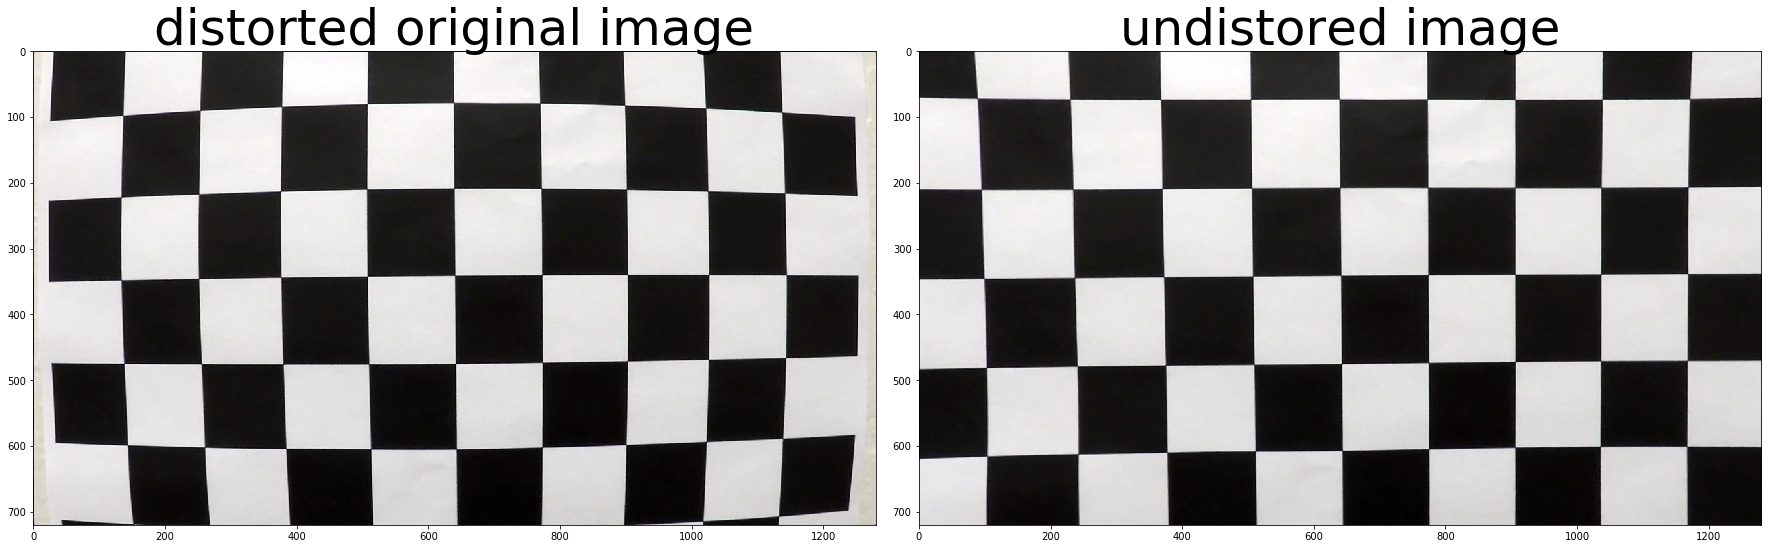

In [3]:
%matplotlib inline
calibrated = True 


if calibrated == False: 
    camera.mtx, camera.dist, camera.rvecs, camera.tvecs = calibrate_camera()
else:
    camera.mtx, camera.dist, camera.rvecs, camera.tvecs = load_calibration()
    
example_image = mpimg.imread('./camera_cal/calibration1.jpg')
    
# Undistort last image in the pipeline  
undistorted = cv2.undistort(example_image, camera.mtx, camera.dist, None, camera.mtx)

# Comparing image 
plot_compare(example_image, undistorted, "distorted original image", "undistored image") 



## Image pipeline implementation 

To be able to process a stream of images, I have to implement a processing pipeline. The following section contains all implemented functions and classes I used to process the video stream frame by frame. Again a lot of code is provided by the udacity course section of this project. 

The image pipeline have to: 
- Undistort & warp image to birds eye view 
- Segment lane lines from image 
- Estimate lanes (polyfit a curve)
- Calculate curvature of lane lines 
- Calculate distane of car center to the middle of the estimated line 
- Project estimated lines into the image for visualization 

The pipeline also could include: 
- Filtering of the calculated polynomal coefficients of the detected line to stabelize the detections (Averaging, Kalman Filtering, ...)
- Sanity checks on estimated lines (curvature change, plausible curvature, lane distance, difference of mean lane position to last frame, ..... ) 


### Segmentation functions 
The following section includes all implemented functions to segment the lane lines in the image using thresholds on gradient and color images. Large parts of the code are provided by the Udacity course during the course section for this project.

First I am going to test gradient and color segmentation on the provided images and experiment with thresholds and combinations of the resulting binary image. 

In [4]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    # 2) Take the derivative in x or y given orient = 'x' or 'y
    if orient == 'x': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else: 
        if orient == 'y':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        else:
            exit()

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output



# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    abs_sobelx = np.absolute(sobelx)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    abs_sobely = np.absolute(sobely)

    # 3) Calculate the magnitude 
    abs_sobelxy = np.absolute(abs_sobelx + abs_sobely)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))

    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
      
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_directions = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_sobelx)
    binary_output[(grad_directions >= thresh[0]) & (grad_directions <= thresh[1])] = 1
   
    # 6) Return this mask as your binary_output image
    return binary_output
 
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    
    hls= img.copy()  # Duplicate image

    # 1) Convert to HLS color space
    hls = cv2.cvtColor(hls, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def RGB_select(img, thresh = (0, 255)): 
    R = test_image[:,:,0]
    thresh = (200, 255)
    binary_output = np.zeros_like(R)
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_output

def undist_image(image, mtx, dist, M, Minv):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted 

Applying the implemented segmenting functions to a test image (a nice one). 

# Loading a test image 
loaded_image = mpimg.imread('./test_images/test0.jpg')
test_image = undist_image(loaded_image, camera.mtx, camera.dist, camera.M, camera.Minv)
plot_compare(loaded_image,test_image, "Original Image" , "Undistored image") 


#############################################################
# HLS color - S threshold 
hls_binary = hls_select(test_image, thresh=(90, 255))
plot_compare(test_image, hls_binary, "Original Image" , "Thresholded HLS Color Channel S") 

#############################################################
# HLS color - S threshold 
R_binary = RGB_select(test_image, thresh=(240, 255))
plot_compare(test_image, R_binary,  "Original Image" ,"Thresholded RGB Color Channel R") 

#############################################################
# Gradient X 
grad_x_binary = abs_sobel_thresh(test_image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
plot_compare(test_image, grad_x_binary,  "Original Image", "Sobel X Thresholded Gradient") 

kernel = np.ones((9,9), np.uint8)
grad_x_dilate = cv2.dilate(grad_x_binary, kernel, iterations=1)
kernel = None 
kernel = np.ones((11,11), np.uint8)
grad_x_erode = cv2.erode(grad_x_dilate, kernel, iterations=1)

#combined_binary_erode = cv2.morphologyEx(mag_binary, cv2.MORPH_OPEN, kernel)

plot_compare(grad_x_dilate, grad_x_erode, "Sobel X Thresh 1.Dilated", "Sobel X Thresh 2.Eroded", True) 
grad_x_binary = grad_x_erode


#############################################################
# Gradient Y
grad_y_binary = abs_sobel_thresh(test_image, orient='y', thresh_min=20, thresh_max=100)
# Plot the result
plot_compare(test_image, grad_y_binary, "Original Image","Sobel Y Thresholded Gradient") 

kernel = np.ones((9,9), np.uint8)
grad_y_dilate = cv2.dilate(grad_y_binary, kernel, iterations=1)
kernel = None 
kernel = np.ones((11,11), np.uint8)
grad_y_erode = cv2.erode(grad_y_dilate, kernel, iterations=1)

#combined_binary_erode = cv2.morphologyEx(mag_binary, cv2.MORPH_OPEN, kernel)

plot_compare(grad_y_dilate, grad_y_erode, "Sobel Y Thresh 1.Dilated", "Sobel Y Thresh 1.Eroded", True) 
grad_y_binary = grad_y_erode

#############################################################
# Gradient Magnitude 
mag_binary = mag_thresh(test_image, sobel_kernel=9, mag_thresh=(30, 100))

# Plot the result
plot_compare(test_image, mag_binary, "Original Image","Thresholded Magnitude") 

kernel = np.ones((9,9), np.uint8)
mag_dilate = cv2.dilate(mag_binary, kernel, iterations=1)

kernel = None 
kernel = np.ones((11,11), np.uint8)
mag_erode = cv2.erode(mag_dilate, kernel, iterations=1)

plot_compare(mag_dilate, mag_erode, "Thresholded Magnitude 1.Dilated", "Thresholded Magnitude 2.Eroded", True) 

mag_binary = mag_erode

#############################################################
# Gradient Direction 
dir_binary = dir_threshold(test_image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
plot_compare(test_image, dir_binary, "Original Image", "Thresholded Grad. Dir.") 

# Only Erode 
kernel = None 
kernel = np.ones((5,5), np.uint8)
dir_erode = cv2.erode(dir_binary, kernel, iterations=1)

plot_compare(dir_binary, dir_erode, "Thresholded Grad. Dir.", "Thresholded Grad. Dir. 1.Eroded", True) 
dir_binary = dir_erode 


#############################################################
# Combined Thresholds 
combined = np.zeros_like(dir_binary)

# Combining gradient based info  
#combined[((grad_x_binary == 1) & (grad_y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Only using grad_x, magnitudem and direction binary and  
#combined = [((grad_x_binary == 1) & (mag_binary == 1) & (dir_binary == 1))] = 1

# Only using magnitude binary 
#combined = mag_binary

# Only using grad_x
combined = grad_x_binary


plot_compare(test_image, combined, "Original image", "Combined gradient binary images") 


#############################################
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(combined), combined, hls_binary)) * 255
#print(color_binary)
plt.imshow(color_binary)
##############################################

# Combine the two binary thresholds
combined_binary = np.zeros_like(combined)
combined_binary[(hls_binary == 1) | (combined == 1)] = 1
plot_compare(test_image, combined_binary, "Original image", "Combined gradient + color binary images", True) 

# Morphological operations on combinded binary images 
kernel = np.ones((5,5), np.uint8)
combined_binary_dilate = cv2.dilate(combined_binary, kernel, iterations=1)
combined_binary_erode = cv2.erode(combined_binary_dilate, kernel, iterations=1)
plot_compare(combined_binary_dilate, combined_binary_erode, "Combined 1.Dilated", "Combined 2.Eroded", True) 

I ended up using a combination of only the thresholded Sobel gradient in X direction. This combination yields in a quite good result. Later only the lower half of the image is going to be used to segment the lane lines, so I do not have to care about the upper half of the image. 

### Undistorting and warping image to birds eye view 

Next I have to take care about the warping into the birds eye view. I decided to do the warping after the thresholding because the lane markings get "semared" over a lot of pixels in the warped image in regions far ahead. Thats because of the foreshortening of the perspective projection --> that means a lack of pixel values in the warped image for regions far ahead. OpenCV is interpolating pixel values in these regions, thats why it looks like the image is "smeared" int this reagions. 

Under the assumption that the lane markings are parallel, I can define four points in the original image and four points defining an rectangle in the warped image. With these points it is possible to calculate a perspective transformation matrix that maps the points in the original image onto the points defined as a rectangle. 

The same algorithm is used by OpenCV to map the identified checkerboard points to the known 3D checkerboard points to calibrate the camera. We are now using this algorithm to warp our image to another view point (also sometimes called a virtual camera). 


In [5]:
def warpto_birdsview(img, mtx, dist, M, Minv): 
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    # Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    return warped 


def get_perspective_transforms(img): 
    
   # Eyeballed transformation points 
    src = np.float32([[200, 720], [453, 547], [835, 547],  [1100, 720]])
    dst = np.float32([[320, 720], [320, 590], [960, 590],  [960, 720]])
 
    # Compute the perspective transform, M, given source and destination points: 
    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse perspective transform: 
    Minv = cv2.getPerspectiveTransform(dst, src)
       
    return M, Minv




I am eyeballing the source and destination points to generate a good looking birdseye view of the scene unsing a test image with straight lane markings. The course secton had given some hints to get the scale of the warped image right, which comes in handy to get the curvature calculation  right: 
- The lane is 3.7 m wide 
- The dashed lines are 3m long 

Its easy to get the line width right and its a little bit harder to geet the height of the rectangle right. According to the number of dashes the birdeye view should have about 30m lookahead. 

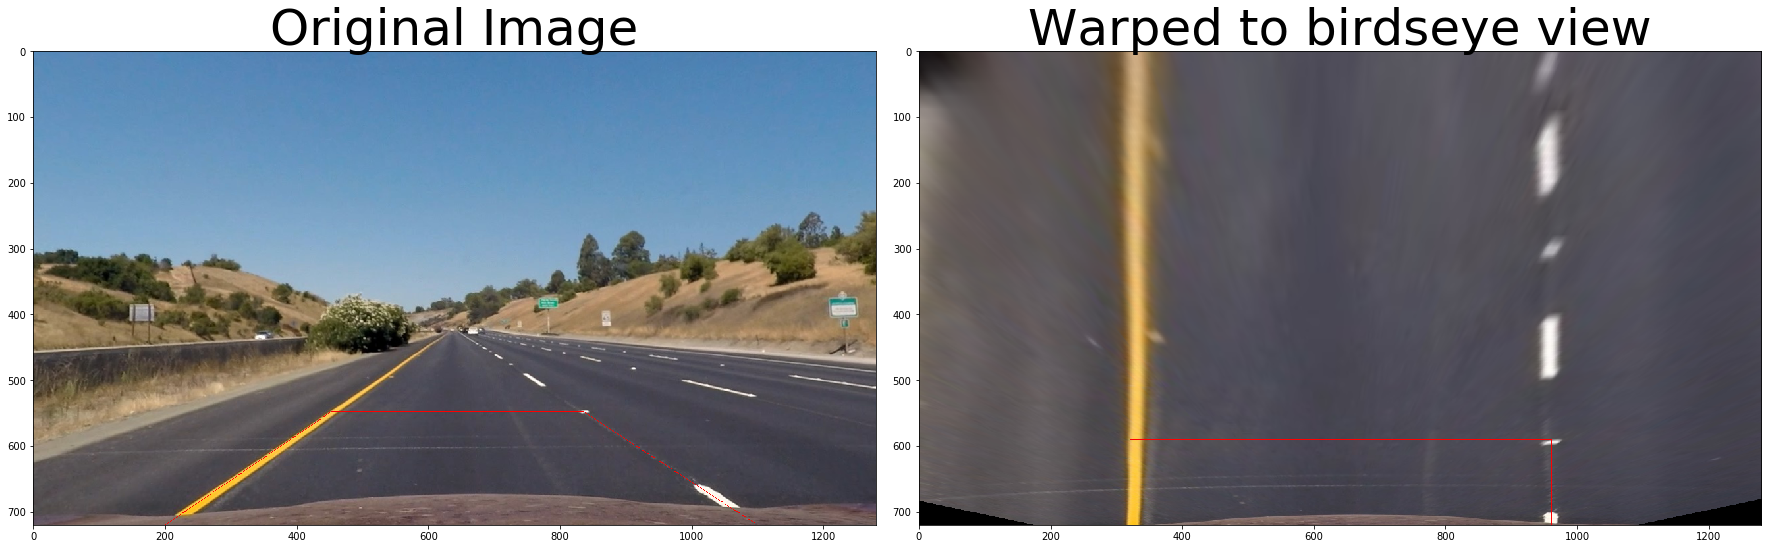

In [6]:
loaded_image = mpimg.imread('./test_images/test0.jpg') 
test_image = undist_image(loaded_image, camera.mtx, camera.dist, camera.M, camera.Minv) 

# Calculating perspective transform 
camera.M, camera.Minv = get_perspective_transforms(test_image) 

# Warping image to birds eye view 
warped_test_image = warpto_birdsview(test_image, camera.mtx, camera.dist, camera.M, camera.Minv)

src = np.array([[200, 720], [453, 547], [835, 547],  [1100, 720]], np.int32)
dst = np.array([[320, 720], [320, 590], [960, 590],  [960, 720]], np.int32)

src = src.reshape((-1,1,2))
cv2.polylines(test_image,[src],True,(255,0,0))

dst = dst.reshape((-1,1,2))
cv2.polylines(warped_test_image,[dst],True,(255,0,0))

plot_compare(test_image, warped_test_image, "Original Image", "Warped to birdseye view", False) 

plt.show()

In [7]:
frame=[]
frame_counter = 0

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        self.kalman_initialized = False
              
        #polynomial coefficients for the most recent fit
        self.current_poly_fit = [0.0,0.0,0.0]  
        self.mean_poly_fit= [0.0, 0.0, 0.0]
        
        self.sigmaABC = [9999.000001,9999.000001,9999.000001] 
        
        self.poly_history = []
        self.mean_poly_history = []

        self.meanA = []
        self.meanB = []
        self.meanC = []
     
        #radius of curvature in meter 
        self.radius_of_curvature = 0.0
        
        #curvature history 
        self.curvature_history = [] 
        self.cuvature_change_history = [] 
        
        # change of radius of curvature 
        self.change_radius_of_curvature = 0.0 
        
        #distance in meters of vehicle center from the line
        self.base_distance_from_lane_center = None 
               
        # Line base coordinates 
        self.lane_base_coordinates = None 
        #x values for detected line pixels
        self.current_pixel_coordinates_x = None  
        
        #y values for detected line pilane_base_coordinatesxels
        self.current_pixel_coordinates_y = None
        
        # y coordinates 
        self.plot_y = None 
        
        # Image poits of line 
        self.line_pts = None  
    
    def update_polyfit_coefficients(self,fit):
        #print("Update  Polyfit coefficients")
        #print("Passed poly fit", fit)

        if self.kalman_initialized == False:
            print("INIT")
            self.mean_poly_fit[0] = fit[0]
            self.mean_poly_fit[1] = fit[1]
            self.mean_poly_fit[2] = fit[2]

            self.meanA.append( self.mean_poly_fit[0])
            self.meanB.append( self.mean_poly_fit[1])
            self.meanC.append( self.mean_poly_fit[2])

            self.poly_history.append(fit)
            self.mean_poly_history.append(self.mean_poly_fit)
            self.kalman_initialized = True 


        self.current_poly_fit = fit

        self.mean_poly_fit[0],self.sigmaABC[0] = update( self.mean_poly_fit[0],self.sigmaABC[0] ,fit[0],1.8)
        self.mean_poly_fit[0], self.sigmaABC[0] = predict(self.mean_poly_fit[0],self.sigmaABC[0],0.0,0.025)

        self.mean_poly_fit[1],self.sigmaABC[1] = update( self.mean_poly_fit[1],self.sigmaABC[1] ,fit[1],1.8)
        self.mean_poly_fit[1], self.sigmaABC[1] = predict(self.mean_poly_fit[1],self.sigmaABC[1],0.0,0.025)

        self.mean_poly_fit[2],self.sigmaABC[2] = update( self.mean_poly_fit[2],self.sigmaABC[2] ,fit[2],1.8)
        self.mean_poly_fit[2], self.sigmaABC[2] = predict(self.mean_poly_fit[2],self.sigmaABC[2],0.0,0.025)

        #print("new mean A",  self.mean_poly_fit[0])
        #print("new mean B", self.mean_poly_fit[1])
        #print("new mean C", self.mean_poly_fit[2])

        self.meanA.append( self.mean_poly_fit[0])
        self.meanB.append( self.mean_poly_fit[1])
        self.meanC.append( self.mean_poly_fit[2])

        self.poly_history.append(fit)
        self.mean_poly_history.append(self.mean_poly_fit)

right_line = Line() 
left_line = Line()

left_poly = []  
right_poly = []  


    
def estimate_base_points(binary_warped, show_plot=True ):
      # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
       

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    
    if show_plot == True:
        fig = plt.figure()
        plt.plot(histogram)
        plt.show()    
  
        histogram_left = histogram[250:midpoint]
        fig = plt.figure()
        plt.plot(histogram_left)    
        plt.show()    


        histogram_right = histogram[midpoint:1100]
        fig = plt.figure()
        plt.plot(histogram_right)    
        plt.show()  
      
    # Assumption - The car is regulary driving in the middle of the lane 
    # Exeptions -> Lane Change 
    # Corping left and right of the histogram 
    
    left_limiter = 220 
    right_limiter = 1150
        
    leftx_base = np.argmax(histogram[left_limiter:midpoint]) + left_limiter
    rightx_base = np.argmax(histogram[midpoint:right_limiter]) + midpoint
    
    return leftx_base, rightx_base 
        

    # input_image = warped binary image 
def detect_lane_lines(input_image, leftx_base, rightx_base, show_plot=True):

    binary_warped = input_image.copy()
    
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*0
    #out_img = out_img.astype(np.uint8)
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 4) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 4) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
          
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty

def get_masked_lane_pixels(gray_wrapped, left_line_pts, right_line_pts, show_plot=True):
    
    out_img_test =  np.zeros_like(gray_wrapped)
    right_mask =  np.zeros_like(gray_wrapped)
    left_mask =  np.zeros_like(gray_wrapped)

    cv2.fillPoly(left_mask, np.int_([left_line_pts]), 255)
    cv2.fillPoly(right_mask, np.int_([right_line_pts]), 255)

    left_masked = cv2.bitwise_and(gray_wrapped, left_mask)
    right_masked = cv2.bitwise_and(gray_wrapped, right_mask)

    if show_plot == True: 
        fig = plt.figure()
        plt.imshow(left_masked, cmap='gray')
        plt.show()

        fig = plt.figure()
        plt.imshow(right_masked, cmap='gray')
        plt.show()

    # We are using EVERY Pixel point for polynomial fitting 
    # Maybe we could the points to fit more wisely 
    nonzero_left = left_masked.nonzero()
    nonzero_left_y = np.array(nonzero_left[0])
    nonzero_left_x = np.array(nonzero_left[1])

    nonzero_right = right_masked.nonzero()
    nonzero_right_y = np.array(nonzero_right[0])
    nonzero_right_x = np.array(nonzero_right[1])


    # Extract left and right line pixel positions
    leftx = nonzero_left_x
    lefty = nonzero_left_y

    rightx = nonzero_right_x
    righty = nonzero_right_y
    return leftx, lefty, rightx, righty 

    
def fit_lane_lines(leftx, lefty, rightx, righty):        
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit 
    
    
def plot_lane_lines(input_image, leftx, lefty, rightx, righty, left_fit, right_fit, show_plot = True):        
    
    binary_warped = input_image.copy()
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*0
    out_img = out_img.astype(np.uint8)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Colorizing the left and right pixels inside of 
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    if show_plot == True:
        fig = plt.figure()

        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    #### Calculate search ROI for next frame 
    
    # Create an image to draw on and an image to show the selection window

    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*0
    #out_img = out_img.astype(np.uint8)

    margin = 100

    
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
     
    if show_plot == True:
        fig = plt.figure()
        plt.imshow(out_img)
    
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
                
    return out_img, left_fitx, right_fitx, ploty, left_line_pts, right_line_pts

def create_overlay(original_input_image, warped_input, left_fitx, right_fitx, ploty, show_plot=True): 
    
    # Create an image to draw the lines on
    warped = warped_input.copy()
    original_image = original_input_image.copy()
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = warped_input
    
    newwarp = cv2.warpPerspective(color_warp, camera.Minv, (original_image.shape[1], original_image.shape[0])) 

    original_image = cv2.addWeighted(original_image, 1, newwarp, 0.4, 0)

    #color_warp = color_warp.astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, camera.Minv, (original_image.shape[1], original_image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    if show_plot == True:
        plt.imshow(result)
    return result 

def calculate_curvature(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    
    
    
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
   
    return left_curverad, right_curverad



def preprocess(image):
    
    input_image = image.copy()
    
    grad_x_binary = abs_sobel_thresh(input_image, orient='x', thresh_min=20, thresh_max=100)
    
    kernel = np.ones((9,9), np.uint8)
    grad_x_dilate = cv2.dilate(grad_x_binary, kernel, iterations=1)

    kernel = None 
    kernel = np.ones((11,11), np.uint8)
    grad_x_binary = cv2.erode(grad_x_dilate, kernel, iterations=1)
    
    #grad_y_binary = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
    
    #mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    #combined_gradient = np.zeros_like(dir_binary)
    #combined_gradient[((grad_x_binary == 1) & (grad_y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
   
    hls_binary = hls_select(input_image, thresh=(170, 255))
    
    #color_binary = np.dstack(( np.zeros_like(combined_gradient), combined_gradient, hls_binary)) * 255
    #combined_binary = np.zeros_like(combined_gradient)
    #combined_binary[(hls_binary == 1) | (combined_gradient == 1)] = 1
    
    
    combined_binary = np.zeros_like(grad_x_binary)

    combined_binary[(hls_binary == 1) | (grad_x_binary == 1)] = 1
    
    
    # Dilate and Erode to fill holes in the binary image of dense blobs and delete clutter 
    kernel = np.ones((5,5), np.uint8)
    combined_binary_dilate = cv2.dilate(combined_binary, kernel, iterations=1)
    combined_binary_erode = cv2.erode(combined_binary_dilate, kernel, iterations=1)
    
    warped_combined_binary = warpto_birdsview(combined_binary_erode, camera.mtx, camera.dist, camera.M, camera.Minv)
        
    return warped_combined_binary 

def update(mean1, var1, mean2, var2):
    new_mean = float(var2 * mean1 + var1 * mean2) / (var1 + var2)
    new_var = 1./(1./var1 + 1./var2)
    return (new_mean, new_var)

def predict(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return (new_mean, new_var)

tracking_state = 1



def pipeline(img_pipe, show_plot = False): 
   
    global frame
    global frame_counter 
    global tracking_state    
        
    preprocessed = preprocess(img_pipe)
    
   
    left_line.detected = False
    right_line.detected = False


    if left_line.detected == False & right_line.detected == False: 
        #print("Detecting line")
        left_line.lane_base_coordinates, \
        right_line.lane_base_coordinates = estimate_base_points(preprocessed,show_plot)
   
    if left_line.detected == False & right_line.detected == False: 
        tracking_state = 1        
        # Detecting Lines 
        new_left_current_pixel_coordinates_x, \
        new_left_current_pixel_coordinates_y, \
        new_right_current_pixel_coordinates_x, \
        new_right_current_pixel_coordinates_y  = detect_lane_lines(preprocessed, \
                                                                   left_line.lane_base_coordinates,\
                                                                   right_line.lane_base_coordinates,\
                                                                   show_plot)
               
        new_left_fit, new_right_fit = fit_lane_lines(new_left_current_pixel_coordinates_x, \
                                                     new_left_current_pixel_coordinates_y, \
                                                     new_right_current_pixel_coordinates_x, \
                                                     new_right_current_pixel_coordinates_y)           
        
        # Filter coefficients 
        left_line.update_polyfit_coefficients(new_left_fit)
        right_line.update_polyfit_coefficients(new_right_fit)
        
                
        # fit lanes 
        processed, \
        left_fitx, \
        right_fitx, \
        ploty, \
        left_line.line_pts, \
        right_line.line_pts = plot_lane_lines(preprocessed, 
                                    new_left_current_pixel_coordinates_x, \
                                    new_left_current_pixel_coordinates_y, \
                                    new_right_current_pixel_coordinates_x, \
                                    new_right_current_pixel_coordinates_y,\
                                    left_line.mean_poly_fit,\
                                    right_line.mean_poly_fit,
                                    show_plot)        
 

        
        # All pixels of last 
        left_line.current_pixel_coordinates_x = new_left_current_pixel_coordinates_x
        left_line.current_pixel_coordinates_y = new_left_current_pixel_coordinates_y
        right_line.current_pixel_coordinates_x = new_right_current_pixel_coordinates_x
        right_line.current_pixel_coordinates_y = new_right_current_pixel_coordinates_y
               
        # Calculate curvature 
        new_left_radius_of_curvature, \
        new_right_radius_of_curvature = calculate_curvature(ploty, \
                                                            left_fitx, \
                                                            right_fitx)\
        
        if((left_line.radius_of_curvature>0) & (right_line.radius_of_curvature > 0)):
            delta_left_curvature = (1/left_line.radius_of_curvature) - (1/new_left_radius_of_curvature)
            delta_right_curvature = (1/right_line.radius_of_curvature) - (1/new_right_radius_of_curvature)
        else:
            delta_left_curvature = 0
            delta_right_curvature = 0
           
        left_line.radius_of_curvature = new_left_radius_of_curvature 
        right_line.radius_of_curvature = new_right_radius_of_curvature 

        ############################### PLOT #############################################
        left_line.curvature_history.append(1/new_left_radius_of_curvature)
        right_line.curvature_history.append(1/new_right_radius_of_curvature)

        #curvature change 
        left_line.cuvature_change_history.append(delta_left_curvature) 
        right_line.cuvature_change_history.append(delta_right_curvature) 
        
        frame_counter = frame_counter + 1
        frame.append(frame_counter)
        
            
       #calculate_curvature
        left_line.detected = True 
        right_line.detected = True 
    else:
        #print("Using masked")
        new_left_current_pixel_coordinates_x, \
        new_left_current_pixel_coordinates_y, \
        new_right_current_pixel_coordinates_x, \
        new_right_current_pixel_coordinates_y  = get_masked_lane_pixels(preprocessed, \
                                                                         left_line.line_pts, \
                                                                         right_line.line_pts, \
                                                                         show_plot)
         
        new_left_fit, new_right_fit = fit_lane_lines(new_left_current_pixel_coordinates_x, \
                                                     new_left_current_pixel_coordinates_y, \
                                                     new_right_current_pixel_coordinates_x, \
                                                     new_right_current_pixel_coordinates_y)           
        
        
        
        
        # Filter coefficients 
        left_line.update_polyfit_coefficients(new_left_fit)
        right_line.update_polyfit_coefficients(new_right_fit)
            
        # fit lanes 
        processed, \
        left_fitx, \
        right_fitx, \
        ploty, \
        left_line.line_pts, \
        right_line.line_pts = plot_lane_lines(preprocessed, 
                                            new_left_current_pixel_coordinates_x, \
                                            new_left_current_pixel_coordinates_y, \
                                            new_right_current_pixel_coordinates_x, \
                                            new_right_current_pixel_coordinates_y,\
                                            left_line.mean_poly_fit,\
                                            right_line.mean_poly_fit,\
                                            show_plot)        
        
        # Calculating curvature 
        new_left_radius_of_curvature, \
        new_right_radius_of_curvature = calculate_curvature(ploty, left_fitx, right_fitx)
             
        # Check curvature - if sanity check fails use last values and set detected to false to retrigger 
        # Detectin in next iteration  
        if((((1/new_left_radius_of_curvature) > 0.0003) | ((1/new_right_radius_of_curvature)<-0.0003)) | \
           (((1/new_right_radius_of_curvature)>0.0003) | ((1/new_right_radius_of_curvature)<-0.0003))): 
            tracking_state = 3       
            # fit lanes 
            
            processed, \
            left_fitx, \
            right_fitx, \
            ploty, \
            left_line.line_pts, \
            right_line.line_pts = plot_lane_lines(preprocessed, 
                                        left_line.current_pixel_coordinates_x, \
                                        left_line.current_pixel_coordinates_y, \
                                        right_line.current_pixel_coordinates_x, \
                                        right_line.current_pixel_coordinates_y,\
                                        left_line.mean_poly_fit,\
                                        right_line.mean_poly_fit,\
                                        show_plot)        
              
            
            # Calculating curvature 
            new_left_radius_of_curvature, \
            new_right_radius_of_curvature = calculate_curvature(ploty, left_fitx, right_fitx)
                        
            delta_left_curvature = (1/left_line.radius_of_curvature) - (1/new_left_radius_of_curvature)
            delta_right_curvature = (1/right_line.radius_of_curvature) - (1/new_right_radius_of_curvature)
            
            ############################### PLOT #############################################
            left_line.curvature_history.append(1/new_left_radius_of_curvature)
            right_line.curvature_history.append(1/new_right_radius_of_curvature)

            #curvature change 
            left_line.cuvature_change_history.append(delta_left_curvature) 
            right_line.cuvature_change_history.append(delta_right_curvature) 
             
            frame_counter = frame_counter + 1
            frame.append(frame_counter)
                         
            
            # Trigger recalc in next interation 
            left_line.detected = False 
            right_line.detected = False 
        else:
            tracking_state = 2       
            
            # Update lines 
            # All pixels of last 
            left_line.current_pixel_coordinates_x = new_left_current_pixel_coordinates_x
            left_line.current_pixel_coordinates_y = new_left_current_pixel_coordinates_y
            right_line.current_pixel_coordinates_x = new_right_current_pixel_coordinates_x
            right_line.current_pixel_coordinates_y = new_right_current_pixel_coordinates_y
                  
            delta_left_curvature = (1/left_line.radius_of_curvature) - (1/new_left_radius_of_curvature)
            delta_right_curvature = (1/right_line.radius_of_curvature) - (1/new_right_radius_of_curvature)

            left_line.radius_of_curvature = new_left_radius_of_curvature 
            right_line.radius_of_curvature = new_right_radius_of_curvature 

            ############################### PLOT #############################################
            left_line.curvature_history.append(1/new_left_radius_of_curvature)
            right_line.curvature_history.append(1/new_right_radius_of_curvature)

            #curvature change 
            left_line.cuvature_change_history.append(delta_left_curvature) 
            right_line.cuvature_change_history.append(delta_right_curvature) 
             
            frame_counter = frame_counter + 1
            frame.append(frame_counter)
   
    #curvature history 

    
  





    result = create_overlay(img_pipe, processed, left_fitx, right_fitx, ploty, False)
   
    
     # ANPASSEN KOPIERT 
    cv2.putText(result,'Frame = %d'%(frame_counter),(55,35), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Left radius (m) = %.2f m'%(left_line.radius_of_curvature),(55,65), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius (m) = %.2f m'%(right_line.radius_of_curvature),(55,95), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2,cv2.LINE_AA)
    
    if tracking_state == 1: 
        cv2.putText(result,'Detecting',(55,125), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    if tracking_state == 2: 
        cv2.putText(result,'Using Mask',(55,125), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    if tracking_state == 3: 
        cv2.putText(result,'Unplausible - using last detection and triggering redetection',(55,125), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result 


Testing Pipeline on a single image with activated debug plots 

In [8]:
#output = pipeline(test_image, True)
#plt.imshow(output)



In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from math import *

left_line.detected = False 
right_line.detected = False 

left_line.curvature_history = []
right_line.curvature_history = [] 

left_line.cuvature_change_history = [] 
right_line.cuvature_change_history = []
frame_counter = 0 
frame = []


frame_counter = 0 

white_output = 'output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds


# First curve 
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)


# Straight 
#clip1 = VideoFileClip("project_video.mp4").subclip(9,13)

# First hard passage with bright apshalt 
#clip1 = VideoFileClip("project_video.mp4").subclip(12,15)

clip1 = VideoFileClip("project_video.mp4")


#clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)

#clip1 = VideoFileClip("challenge_video.mp4")


#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

INIT
INIT
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [03:39<00:00,  5.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 4min 6s, sys: 14.3 s, total: 4min 21s
Wall time: 3min 41s


Saving Results
Saving completed
Loading Results
Loading complete
1262
mean poly isthori 3.3585898545233734e-05
mean poly isthori 3.3585898545233734e-05
mean poly isthori 3.3585898545233734e-05
mean poly isthori [3.3585898545233734e-05, -0.10246203812974246, 1104.6609357000968]
mean poly isthori [3.3585898545233734e-05, -0.10246203812974246, 1104.6609357000968]
mean poly isthori [3.3585898545233734e-05, -0.10246203812974246, 1104.6609357000968]
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 

poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05

poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05

mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05
mean poly isthori 3.3585898545233734e-05
poly isthori 1.2784066128364411e-05

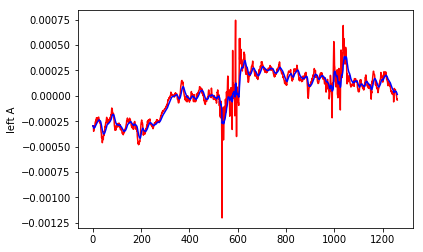

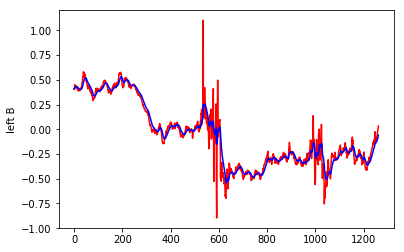

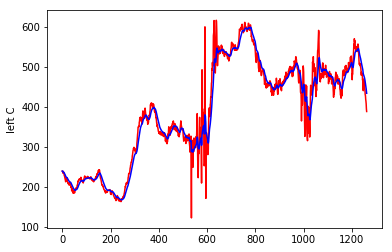

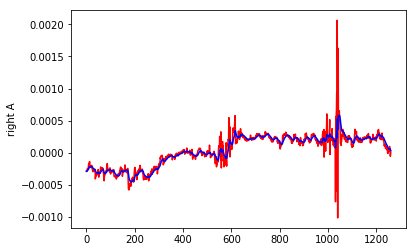

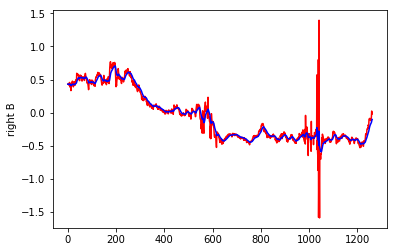

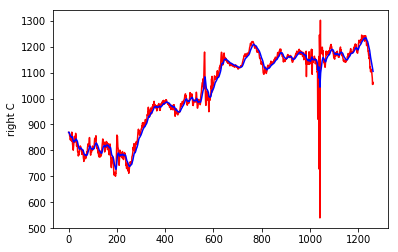

In [10]:




#left_poly = np.vstack(left_poly)
#right_poly = np.vstack(right_poly)






print("Saving Results")
f = open('poly_fit_left_right_3.pkl', 'wb')
ret_dump = False 
ret_dump = pickle.dump([left_poly, \
                        right_poly], f)
f.close()
print("Saving completed")


# Loading calibration
print("Loading Results")
f = open('poly_fit_left_right_3.pkl', 'rb')
loaded_left_poly, \
loaded_right_poly = pickle.load(f)
f.close()
print("Loading complete")



leftA = []
leftB = []
leftC = []

rightA = []
rightB = []
rightC = []

meanleftA = []
meanleftB = []
meanleftC = []

meanrightA = []
meanrightB = []
meanrightC = []


print(len(left_line.poly_history))



print("mean poly isthori",  right_line.mean_poly_history[0][0])
print("mean poly isthori",  right_line.mean_poly_history[1][0])
print("mean poly isthori",  right_line.mean_poly_history[2][0])


print("mean poly isthori",  right_line.mean_poly_history[0])
print("mean poly isthori",  right_line.mean_poly_history[1])
print("mean poly isthori",  right_line.mean_poly_history[2])


#exit()


for i in range(len(left_line.poly_history)):
    
 
    
    leftA.append(left_line.poly_history[i][0])
    leftB.append(left_line.poly_history[i][1])
    leftC.append(left_line.poly_history[i][2])
    
    meanleftA.append(left_line.mean_poly_history[i][0])
    meanleftB.append(left_line.mean_poly_history[i][1])
    meanleftC.append(left_line.mean_poly_history[i][2])
          
    rightA.append(right_line.poly_history[i][0])
    rightB.append(right_line.poly_history[i][1])
    rightC.append(right_line.poly_history[i][2])

    #print("poly isthori",  left_line.mean_poly_history[i][0])  
    #print("mean poly isthori",  right_line.mean_poly_history[i][0])
    
    meanrightA.append(right_line.mean_poly_history[i][0])
    meanrightB.append(right_line.mean_poly_history[i][1])
    meanrightC.append(right_line.mean_poly_history[i][2])

fig = plt.figure()
plt.plot(leftA, 'r', left_line.meanA, 'b')
plt.ylabel('left A')
plt.show()

fig = plt.figure()
plt.plot(leftB, 'r', left_line.meanB, 'b')
plt.ylabel('left B')
plt.show()

fig = plt.figure()
plt.plot(leftC, 'r', left_line.meanC, 'b')
plt.ylabel('left C')
plt.show()


fig = plt.figure()
plt.plot(rightA, 'r', right_line.meanA, 'b')
plt.ylabel('right A')
plt.show()

fig = plt.figure()
plt.plot(rightB, 'r', right_line.meanB, 'b')
plt.ylabel('right B')
plt.show()

fig = plt.figure()
plt.plot(rightC, 'r', right_line.meanC, 'b')
plt.ylabel('right C')
plt.show()

Loading Results
Loading complete


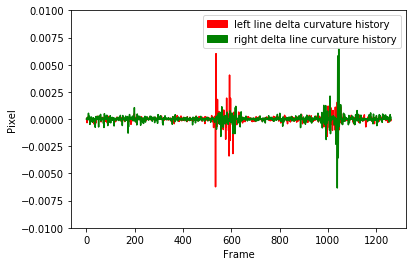

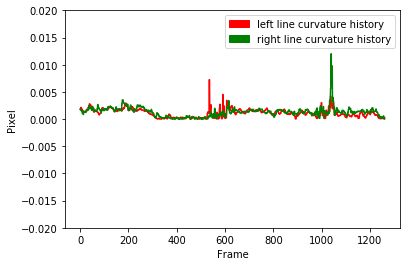

In [11]:
 %matplotlib qt




save = False 
if save == False: 
    #importing some useful packages
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import cv2
    import glob 
    import os
    import math
    import pickle
    import matplotlib.patches as mpatches

    
    left_line = Line()
    right_line = Line()



if save == True: 
    print("Saving Results")
    f = open('curvature_plot_3.pkl', 'wb')
    ret_dump = False 
    ret_dump = pickle.dump([left_line.curvature_history, \
                            right_line.curvature_history, \
                            left_line.cuvature_change_history, \
                            right_line.cuvature_change_history,\
                            frame], f)
    f.close()
    print("Saving completed")
else:
     # Loading calibration
    print("Loading Results")
    f = open('curvature_plot_CURVATURE_DELTA_THRESHOLD_FULL_VIDEO.pkl', 'rb')
    left_line.curvature_history, \
    right_line.curvature_history, \
    left_line.cuvature_change_history, \
    right_line.cuvature_change_history,\
    frame = pickle.load(f)
    f.close()
    print("Loading complete")
     

        
        

fig = plt.figure()
red_patch = mpatches.Patch(color='red', label='left line delta curvature history')
green_patch = mpatches.Patch(color='green', label='right delta line curvature history')
plt.legend(handles=[red_patch, green_patch])
axes = plt.gca()
axes.set_ylim([-0.010,0.010])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, left_line.cuvature_change_history, 'r', frame, right_line.cuvature_change_history, 'g')
plt.show()        
        
        
        
        
        
        
        
        
fig = plt.figure()
red_patch = mpatches.Patch(color='red', label='left line curvature history')
green_patch = mpatches.Patch(color='green', label='right line curvature history')
plt.legend(handles=[red_patch, green_patch])
axes = plt.gca()
axes.set_ylim([-0.020,0.020])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, left_line.curvature_history, 'r', frame, right_line.curvature_history, 'g')
plt.show()

